Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# MAISI Inference Tutorial

This tutorial illustrates how to use trained MAISI model and codebase to generate synthetic 3D images and paired masks.

`[Release Note (March 2025)]:` We are excited to announce the new MAISI Version `'maisi3d-rflow'`. Compared with the previous version `'maisi3d-ddpm'`, it accelerated latent diffusion model inference by 33x. Please see the detailed difference in the following section.

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
import argparse
import json
import os
import tempfile

import monai
import torch
from monai.apps import download_url
from monai.config import print_config
from monai.transforms import LoadImage, Orientation
from monai.utils import set_determinism
from scripts.sample import LDMSampler, check_input
from scripts.utils import define_instance
from scripts.utils_plot import find_label_center_loc, get_xyz_plot, show_image
from scripts.diff_model_setting import setup_logging

print_config()

logger = setup_logging("notebook")

MONAI version: 1.4.1rc1+32.g34f37973
Numpy version: 1.26.4
Pytorch version: 2.5.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 34f379735c5e18e7f809453eb1b3606c225c788b
MONAI __file__: /localhome/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.20.0+cu124
tqdm version: 4.66.5
lmdb version: 1.5.1
psutil version: 6.1.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.17.1
pynrrd version: 1.0.0
clearml version: 1.16.5rc2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set up the MAISI version

Choose between `'maisi3d-ddpm'` and `'maisi3d-rflow'`. The differences are:
- The maisi version `'maisi3d-ddpm'` uses basic noise scheduler DDPM. `'maisi3d-rflow'` uses Rectified Flow scheduler, can be 33 times faster during inference.
- The maisi version `'maisi3d-ddpm'` requires training images to be labeled with body region (`"top_region_index"` and `"bottom_region_index"`), while `'maisi3d-rflow'` does not have such requirement. In other words, it is easier to prepare training data for `'maisi3d-rflow'`.
- For the released model weights, `'maisi3d-rflow'` can generate images with better quality for head region and small output volumes, and comparable quality for other cases compared with `'maisi3d-ddpm'`.

In [3]:
maisi_version = "maisi3d-rflow"
if maisi_version == "maisi3d-ddpm":
    model_def_path = "./configs/config_maisi3d-ddpm.json"
elif maisi_version == "maisi3d-rflow":
    model_def_path = "./configs/config_maisi3d-rflow.json"
else:
    raise ValueError(f"maisi_version has to be chosen from ['maisi3d-ddpm', 'maisi3d-rflow'], yet got {maisi_version}.")
with open(model_def_path, "r") as f:
    model_def = json.load(f)
include_body_region = model_def["include_body_region"]
logger.info(f"MAISI version is {maisi_version}, whether to use body_region is {include_body_region}")

[2025-03-19 05:06:22.467][ INFO](notebook) - MAISI version is maisi3d-rflow, whether to use body_region is False


## Setup data directory
You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable. This allows you to save results and reuse downloads. If not specified a temporary directory will be used.

In [4]:
os.environ["MONAI_DATA_DIRECTORY"] = "temp_work_dir_inference_demo"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory

# TODO: remove the `files` after the files are uploaded to the NGC
files = [
    {
        "path": "models/autoencoder_epoch273.pt",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai/tutorials"
        "/model_zoo/model_maisi_autoencoder_epoch273_alternative.pt",
    },
    {
        "path": "models/mask_generation_autoencoder.pt",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai" "/tutorials/mask_generation_autoencoder.pt",
    },
    {
        "path": "models/mask_generation_diffusion_unet.pt",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai"
        "/tutorials/model_zoo/model_maisi_mask_generation_diffusion_unet_v2.pt",
    },
    {
        "path": "configs/all_anatomy_size_condtions.json",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/all_anatomy_size_condtions.json",
    },
    {
        "path": "datasets/all_masks_flexible_size_and_spacing_4000.zip",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai"
        "/tutorials/all_masks_flexible_size_and_spacing_4000.zip",
    },
]

if maisi_version == "maisi3d-ddpm":
    files += [
        {
            "path": "models/diff_unet_3d_ddpm.pt",
            "url": "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/model_zoo"
            "/model_maisi_input_unet3d_data-all_steps1000size512ddpm_random_current_inputx_v1_alternative.pt",
        },
        {
            "path": "models/controlnet_3d_ddpm.pt",
            "url": "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/model_zoo"
            "/model_maisi_controlnet-20datasets-e20wl100fold0bc_noi_dia_fsize_current_alternative.pt",
        },
        {
            "path": "configs/candidate_masks_flexible_size_and_spacing_3000.json",
            "url": "https://developer.download.nvidia.com/assets/Clara/monai"
            "/tutorials/candidate_masks_flexible_size_and_spacing_3000.json",
        },
    ]
elif maisi_version == "maisi3d-rflow":
    files += [
        {
            "path": "models/diff_unet_3d_rflow.pt",
            "url": "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/"
            "diff_unet_ckpt_rflow_epoch19350.pt",
        },
        {
            "path": "models/controlnet_3d_rflow.pt",
            "url": "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/controlnet_rflow_epoch60.pt",
        },
        {
            "path": "configs/candidate_masks_flexible_size_and_spacing_4000.json",
            "url": "https://developer.download.nvidia.com/assets/Clara/monai"
            "/tutorials/candidate_masks_flexible_size_and_spacing_4000.json",
        },
    ]
else:
    raise ValueError(f"maisi_version has to be chosen from ['maisi3d-ddpm', 'maisi3d-rflow'], yet got {maisi_version}.")

for file in files:
    file["path"] = file["path"] if "datasets/" not in file["path"] else os.path.join(root_dir, file["path"])
    download_url(url=file["url"], filepath=file["path"])

2025-03-19 05:06:22,476 - INFO - Expected md5 is None, skip md5 check for file models/autoencoder_epoch273.pt.
2025-03-19 05:06:22,477 - INFO - File exists: models/autoencoder_epoch273.pt, skipped downloading.
2025-03-19 05:06:22,478 - INFO - Expected md5 is None, skip md5 check for file models/mask_generation_autoencoder.pt.
2025-03-19 05:06:22,478 - INFO - File exists: models/mask_generation_autoencoder.pt, skipped downloading.
2025-03-19 05:06:22,479 - INFO - Expected md5 is None, skip md5 check for file models/mask_generation_diffusion_unet.pt.
2025-03-19 05:06:22,480 - INFO - File exists: models/mask_generation_diffusion_unet.pt, skipped downloading.
2025-03-19 05:06:22,481 - INFO - Expected md5 is None, skip md5 check for file configs/all_anatomy_size_condtions.json.
2025-03-19 05:06:22,482 - INFO - File exists: configs/all_anatomy_size_condtions.json, skipped downloading.
2025-03-19 05:06:22,482 - INFO - Expected md5 is None, skip md5 check for file temp_work_dir_inference_demo/

## Read in environment setting, including data directory, model directory, and output directory

The information for data directory, model directory, and output directory are saved in ./configs/environment.json

In [5]:
args = argparse.Namespace()

if maisi_version == "maisi3d-ddpm":
    environment_file = "./configs/environment_maisi3d-ddpm.json"
elif maisi_version == "maisi3d-rflow":
    environment_file = "./configs/environment_maisi3d-rflow.json"
else:
    raise ValueError(f"maisi_version has to be chosen from ['maisi3d-ddpm', 'maisi3d-rflow'], yet got {maisi_version}.")

with open(environment_file, "r") as f:
    env_dict = json.load(f)
for k, v in env_dict.items():
    # Update the path to the downloaded dataset in MONAI_DATA_DIRECTORY
    val = v if "datasets/" not in v else os.path.join(root_dir, v)
    setattr(args, k, val)
    logger.info(f"{k}: {val}")
logger.info("Global config variables have been loaded.")

[2025-03-19 05:06:22.493][ INFO](notebook) - output_dir: output
[2025-03-19 05:06:22.494][ INFO](notebook) - trained_autoencoder_path: models/autoencoder_epoch273.pt
[2025-03-19 05:06:22.494][ INFO](notebook) - trained_diffusion_path: models/diff_unet_3d_rflow.pt
[2025-03-19 05:06:22.495][ INFO](notebook) - trained_controlnet_path: models/controlnet_3d_rflow.pt
[2025-03-19 05:06:22.496][ INFO](notebook) - trained_mask_generation_autoencoder_path: models/mask_generation_autoencoder.pt
[2025-03-19 05:06:22.497][ INFO](notebook) - trained_mask_generation_diffusion_path: models/mask_generation_diffusion_unet.pt
[2025-03-19 05:06:22.497][ INFO](notebook) - all_mask_files_base_dir: temp_work_dir_inference_demo/datasets/all_masks_flexible_size_and_spacing_4000
[2025-03-19 05:06:22.498][ INFO](notebook) - all_mask_files_json: ./configs/candidate_masks_flexible_size_and_spacing_4000.json
[2025-03-19 05:06:22.498][ INFO](notebook) - all_anatomy_size_conditions_json: ./configs/all_anatomy_size_co

## Read in configuration setting, including network definition, body region and anatomy to generate, etc.

The information for the inference input, like body region and anatomy to generate, is stored in "./configs/config_infer.json". Please refer to README.md for the details.

In [6]:
with open(model_def_path, "r") as f:
    model_def = json.load(f)
for k, v in model_def.items():
    setattr(args, k, v)

# check the format of inference inputs
config_infer_file = "./configs/config_infer.json"
with open(config_infer_file, "r") as f:
    config_infer_dict = json.load(f)
for k, v in config_infer_dict.items():
    setattr(args, k, v)
    logger.info(f"{k}: {v}")

check_input(
    args.body_region,
    args.anatomy_list,
    args.label_dict_json,
    args.output_size,
    args.spacing,
    args.controllable_anatomy_size,
)
latent_shape = [args.latent_channels, args.output_size[0] // 4, args.output_size[1] // 4, args.output_size[2] // 4]
logger.info("Network definition and inference inputs have been loaded.")

[2025-03-19 05:06:22.508][ INFO](notebook) - num_output_samples: 1
[2025-03-19 05:06:22.509][ INFO](notebook) - body_region: ['chest']
[2025-03-19 05:06:22.509][ INFO](notebook) - anatomy_list: ['lung tumor']
[2025-03-19 05:06:22.510][ INFO](notebook) - controllable_anatomy_size: []
[2025-03-19 05:06:22.510][ INFO](notebook) - num_inference_steps: 30
[2025-03-19 05:06:22.512][ INFO](notebook) - mask_generation_num_inference_steps: 1000
[2025-03-19 05:06:22.512][ INFO](notebook) - output_size: [256, 256, 256]
[2025-03-19 05:06:22.513][ INFO](notebook) - image_output_ext: .nii.gz
[2025-03-19 05:06:22.514][ INFO](notebook) - label_output_ext: .nii.gz
[2025-03-19 05:06:22.514][ INFO](notebook) - spacing: [1.5, 1.5, 2.0]
[2025-03-19 05:06:22.515][ INFO](notebook) - autoencoder_sliding_window_infer_size: [48, 48, 48]
[2025-03-19 05:06:22.515][ INFO](notebook) - autoencoder_sliding_window_infer_overlap: 0.6666
[2025-03-19 05:06:22.516][ INFO](notebook) - controlnet: $@controlnet_def
[2025-03-

## Set deterministic training for reproducibility

In [7]:
set_determinism(seed=0)
args.random_seed = 0

## Initialize networks and noise scheduler, then load the trained model weights.

The networks and noise scheduler are defined in `config_maisi.json`. We will read them in and load the model weights.

In [8]:
noise_scheduler = define_instance(args, "noise_scheduler")
mask_generation_noise_scheduler = define_instance(args, "mask_generation_noise_scheduler")

device = torch.device("cuda")

autoencoder = define_instance(args, "autoencoder_def").to(device)
checkpoint_autoencoder = torch.load(args.trained_autoencoder_path, weights_only=True)
autoencoder.load_state_dict(checkpoint_autoencoder)

diffusion_unet = define_instance(args, "diffusion_unet_def").to(device)
checkpoint_diffusion_unet = torch.load(args.trained_diffusion_path, weights_only=False)
diffusion_unet.load_state_dict(checkpoint_diffusion_unet["unet_state_dict"], strict=True)
scale_factor = checkpoint_diffusion_unet["scale_factor"].to(device)

controlnet = define_instance(args, "controlnet_def").to(device)
checkpoint_controlnet = torch.load(args.trained_controlnet_path, weights_only=False)
monai.networks.utils.copy_model_state(controlnet, diffusion_unet.state_dict())
controlnet.load_state_dict(checkpoint_controlnet["controlnet_state_dict"], strict=True)

mask_generation_autoencoder = define_instance(args, "mask_generation_autoencoder_def").to(device)
checkpoint_mask_generation_autoencoder = torch.load(args.trained_mask_generation_autoencoder_path, weights_only=True)
mask_generation_autoencoder.load_state_dict(checkpoint_mask_generation_autoencoder)

mask_generation_diffusion_unet = define_instance(args, "mask_generation_diffusion_def").to(device)
checkpoint_mask_generation_diffusion_unet = torch.load(args.trained_mask_generation_diffusion_path, weights_only=True)
mask_generation_diffusion_unet.load_state_dict(checkpoint_mask_generation_diffusion_unet["unet_state_dict"])
mask_generation_scale_factor = checkpoint_mask_generation_diffusion_unet["scale_factor"]

logger.info("All the trained model weights have been loaded.")

2025-03-19 05:06:28,553 - INFO - 'dst' model updated: 180 of 231 variables.


[2025-03-19 05:06:30.944][ INFO](notebook) - All the trained model weights have been loaded.


## Define the LDM Sampler, which contains functions that will perform the inference.

In [9]:
ldm_sampler = LDMSampler(
    args.body_region,
    args.anatomy_list,
    args.all_mask_files_json,
    args.all_anatomy_size_conditions_json,
    args.all_mask_files_base_dir,
    args.label_dict_json,
    args.label_dict_remap_json,
    autoencoder,
    diffusion_unet,
    controlnet,
    noise_scheduler,
    scale_factor,
    mask_generation_autoencoder,
    mask_generation_diffusion_unet,
    mask_generation_scale_factor,
    mask_generation_noise_scheduler,
    device,
    latent_shape,
    args.mask_generation_latent_shape,
    args.output_size,
    args.output_dir,
    args.controllable_anatomy_size,
    image_output_ext=args.image_output_ext,
    label_output_ext=args.label_output_ext,
    spacing=args.spacing,
    modality=args.modality,
    num_inference_steps=args.num_inference_steps,
    mask_generation_num_inference_steps=args.mask_generation_num_inference_steps,
    random_seed=args.random_seed,
    autoencoder_sliding_window_infer_size=args.autoencoder_sliding_window_infer_size,
    autoencoder_sliding_window_infer_overlap=args.autoencoder_sliding_window_infer_overlap,
)

[2025-03-19 05:06:30.969][ INFO](root) - LDM sampler initialized.


## Perform the inference
**Time cost:** It will take around 80s to generate a [256,256,256] mask, and another 105s to generate the corresponding [256,256,256] image on one A100. The time cost per mask is fixed; time cost per image is roughly linear to the output size. i.e., if we want to generate a [512,512,512] image/mask pair, it will take around 80s to generate a [256,256,256] mask and then resample it to a [512,512,512] mask. The time cost for [512,512,512] image generatation will be 8 times longer, around 8x105s~14min. 

**GPU memory:** Decoding the latents into image with autoencoder is the step that consumes the largest GPU memory. The mask generation takes 34G. For image generation, to save GPU memory, we use sliding window inference for the autoencoder when the `output_size` is large. So the GPU memory for image generation is not strictly linear to the output_size. For [256,256,256], it takes 34G. For [512,512,512], it takes 67G.

In [10]:
logger.info(f"The generated image/mask pairs will be saved in {args.output_dir}.")
output_filenames = ldm_sampler.sample_multiple_images(args.num_output_samples)
logger.info("MAISI image/mask generation finished")

[2025-03-19 05:06:30.974][ INFO](notebook) - The generated image/mask pairs will be saved in output.
[2025-03-19 05:06:31.018][ INFO](root) - Resample mask file to get desired output size and spacing
[2025-03-19 05:06:32.950][ INFO](root) - Resampling mask to target shape and spacing
[2025-03-19 05:06:32.953][ INFO](root) - Resize Spacing: [tensor(0.7988, dtype=torch.float64), tensor(0.7988, dtype=torch.float64), tensor(1.1016, dtype=torch.float64)] -> [1.5, 1.5, 2.0]
[2025-03-19 05:06:32.954][ INFO](root) - Output size: [512, 512, 384] -> [256, 256, 256]
[2025-03-19 05:06:35.876][ INFO](root) - Resampling mask to target shape and spacing
[2025-03-19 05:06:35.878][ INFO](root) - Resize Spacing: [tensor(0.7031, dtype=torch.float64), tensor(0.7031, dtype=torch.float64), tensor(1.4795, dtype=torch.float64)] -> [1.5, 1.5, 2.0]
[2025-03-19 05:06:35.879][ INFO](root) - Output size: [512, 512, 256] -> [256, 256, 256]
[2025-03-19 05:06:38.564][ INFO](root) - Resampling mask to target shape and

augmenting lung tumor
28
metatensor(180., device='cuda:0') | metatensor(547.4000, device='cuda:0')


[2025-03-19 05:06:52.345][ INFO](root) - ---- Mask preparation time: 4.489694595336914 seconds ----
[2025-03-19 05:06:52.363][ INFO](root) - ---- Start generating latent features... ----


metatensor(687., device='cuda:0') | metatensor(547.4000, device='cuda:0')


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.58it/s]
[2025-03-19 05:06:58.962][ INFO](root) - ---- DM/ControlNet Latent features generation time: 6.598896265029907 seconds ----
[2025-03-19 05:06:59.051][ INFO](root) - ---- Start decoding latent features into images... ----
100%|█████████████████████████████████████████████| 8/8 [00:11<00:00,  1.42s/it]
[2025-03-19 05:07:10.494][ INFO](root) - ---- Image VAE decoding time: 11.442715883255005 seconds ----


1 5
2025-03-19 05:07:10,994 INFO image_writer.py:197 - writing: output/sample_20250319_050710_975233_image.nii.gz
2025-03-19 05:07:12,461 INFO image_writer.py:197 - writing: output/sample_20250319_050710_975233_label.nii.gz


[2025-03-19 05:07:13.422][ INFO](notebook) - MAISI image/mask generation finished


## Visualize the results


[2025-03-19 05:07:13.430][ INFO](notebook) - Visualizing output/sample_20250319_050710_975233_image.nii.gz and output/sample_20250319_050710_975233_label.nii.gz...


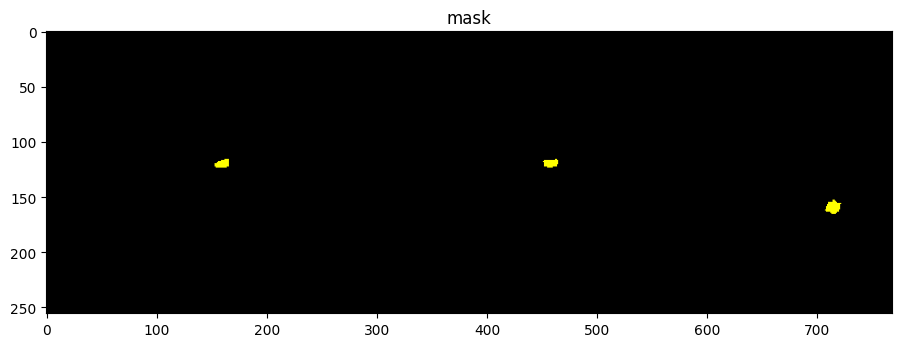

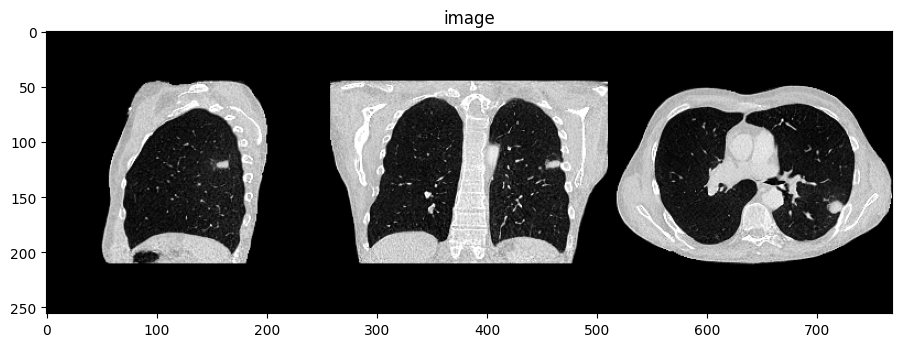

In [11]:
visualize_image_filename = output_filenames[0][0]
visualize_mask_filename = output_filenames[0][1]
logger.info(f"Visualizing {visualize_image_filename} and {visualize_mask_filename}...")

# load image/mask pairs
loader = LoadImage(image_only=True, ensure_channel_first=True)
orientation = Orientation(axcodes="RAS")
image_volume = orientation(loader(visualize_image_filename))
mask_volume = orientation(loader(visualize_mask_filename)).to(torch.uint8)

# visualize for CT HU intensity between [-200, 500]
image_volume = torch.clip(image_volume, -1000, 300)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

# create a random color map for mask visualization
colorize = torch.clip(torch.cat([torch.zeros(3, 1, 1, 1), torch.randn(3, 200, 1, 1)], 1), 0, 1)
target_class_index = 1

# find center voxel location for 2D slice visualization
center_loc_axis = find_label_center_loc(torch.flip(mask_volume[0, ...] == target_class_index, [-3, -2, -1]))

# visualization
vis_mask = get_xyz_plot(
    mask_volume, center_loc_axis, mask_bool=True, n_label=201, colorize=colorize, target_class_index=target_class_index
)
show_image(vis_mask, title="mask")

vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="image")